**IMPORT LIBRARIES**

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from statsmodels.tsa.seasonal import seasonal_decompose
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings('ignore')

2024-12-01 16:08:35.367113: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


**1.0 Read Data**

In [2]:
goldprice = pd.read_csv("Gold Price (2013-2023).csv")


**2.0 Display Basic Data Information**

In [3]:
goldprice.head()

Date     Price      Open      High       Low     Vol. Change %
0  12/30/2022  1,826.20  1,821.80  1,832.40  1,819.80  107.50K    0.01%
1  12/29/2022  1,826.00  1,812.30  1,827.30  1,811.20  105.99K    0.56%
2  12/28/2022  1,815.80  1,822.40  1,822.80  1,804.20  118.08K   -0.40%
3  12/27/2022  1,823.10  1,808.20  1,841.90  1,808.00  159.62K    0.74%
4  12/26/2022  1,809.70  1,805.80  1,811.95  1,805.55      NaN    0.30%

In [7]:
goldprice.dtypes

Date        object
Price       object
Open        object
High        object
Low         object
Vol.        object
Change %    object
dtype: object

In [9]:
goldprice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2583 entries, 0 to 2582
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      2583 non-null   object
 1   Price     2583 non-null   object
 2   Open      2583 non-null   object
 3   High      2583 non-null   object
 4   Low       2583 non-null   object
 5   Vol.      2578 non-null   object
 6   Change %  2583 non-null   object
dtypes: object(7)
memory usage: 141.4+ KB


In [17]:
goldprice.describe()

Date
count                           2583
mean   2018-01-02 02:17:08.571428608
min              2013-01-02 00:00:00
25%              2015-07-02 12:00:00
50%              2018-01-03 00:00:00
75%              2020-07-04 12:00:00
max              2022-12-30 00:00:00

**3.0 DATA TRANSFORMATION**

**3.1 Drop Volume and Change%**

They have very insignificant correlation with gold price and also irrelevant in predidcitng gold price for the future  

In [19]:
goldprice.drop(['Vol.', 'Change %'], axis=1, inplace=True)

**3.2 Remove Redundant features and Change Numerical Data Type to Float**

The comma (",") symbol is unnecessary in the dataset. Remove it across the dataset, then convert the numerical columns to a float data type.

In [21]:
goldprice['Date'] = pd.to_datetime(goldprice['Date'])
goldprice.sort_values(by='Date', ascending=True, inplace=True)
goldprice.reset_index(drop=True, inplace=True)

In [23]:
Numerical_Columns = goldprice.columns.drop(['Date'])
goldprice[Numerical_Columns] = goldprice[Numerical_Columns].replace({',': ''}, regex=True)
goldprice[Numerical_Columns] = goldprice[Numerical_Columns].astype('float64')
goldprice.head()

Date   Price    Open    High     Low
0 2013-01-02  1689.9  1675.8  1695.0  1672.1
1 2013-01-03  1675.6  1688.0  1689.3  1664.3
2 2013-01-04  1649.9  1664.4  1664.4  1630.0
3 2013-01-07  1647.2  1657.3  1663.8  1645.3
4 2013-01-08  1663.2  1651.5  1662.6  1648.8

**3.3 Check Duplicate Data**

In [25]:
goldprice.duplicated().sum()

0

**3.3 Check Misssing Data**

In [27]:
goldprice.isnull().sum().sum()

0

**4.0 EXPLORATORY DATA ANALYSIS**

**4.1 Gold Price History Across The Years**

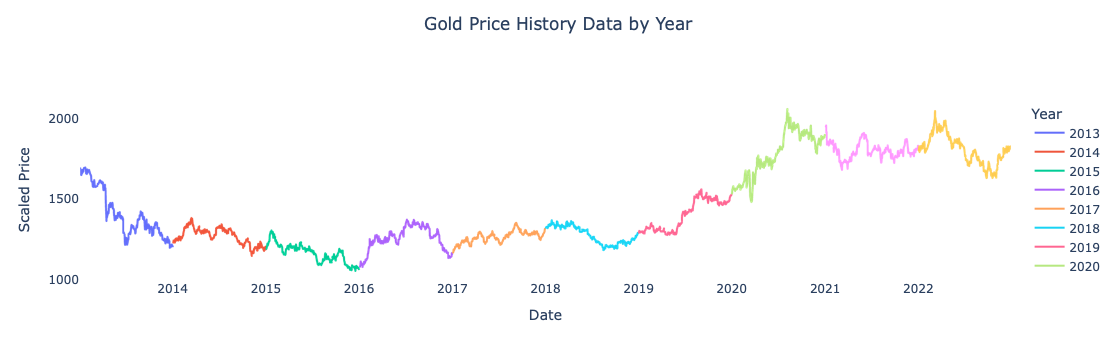

In [29]:
goldprice['Year'] = goldprice['Date'].dt.year
fig = px.line(goldprice, x='Date', y='Price', color='Year',
              title="Gold Price History Data by Year",
              labels={"Date": "Date", "Price": "Scaled Price"})
fig.update_traces(line=dict(width=2))
fig.update_layout(
    title_x=0.5,
    title_y=0.95,
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)',
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False)
)
fig.show()


1.	The graph indicates a long-term upward trend in the gold price, particularly from 2019 to 2020, with a peak occurring around 2020.
2.	The gold price initially falls from about 1600 USD in 2013 to around 1200 USD in 2015. This represents a period of price decline.
3.	From 2015 to 2019, the price fluctuates but stays within the range of 1200 to 1400 USD, indicating a relatively stable period.
4.	Around 2019, the price of gold begins to rise sharply, reaching its highest value of over 2000 USD by mid-2020. This surge may reflect increased demand due to global uncertainties, such as the onset of the COVID-19 pandemic.
5.	After reaching a peak in 2020, the price declines slightly but remains volatile, with prices fluctuating between 1800 to 2000 USD. Despite this volatility, the gold price stays significantly higher than its 2013–2019 levels.
6.	Towards 2023, the price appears to stabilize again but at a higher level than in previous years, around 1800 USD.


**4.2 Box Plot of Gold Price Distribution Across the Years**

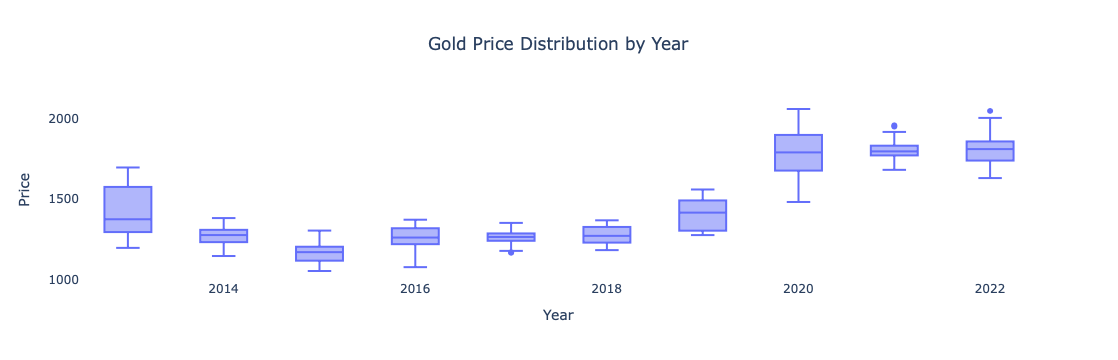

In [31]:
fig = px.box(goldprice, x='Year', y='Price', title="Gold Price Distribution by Year",
             labels={"Year": "Year", "Price": "Price"})
fig.update_layout(title_x=0.5, plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)',
                  xaxis=dict(showgrid=False), yaxis=dict(showgrid=False))
fig.show()


2014:
1. Gold prices show a wide range, with the median price around 1400.
2. There is significant variation in prices, spanning approximately from 1200 to 1600.

2015-2019:
1. Gold prices show less variation compared to 2014.
2. The median prices remain relatively stable within a range of approximately 1200 to 1300.
3. The boxes for these years are relatively short, indicating less price volatility.
4. 2016 shows a slight increase in the range compared to the adjacent years.

2020:
1. There is a notable increase in both the median and the price range.
2. Prices vary widely, with values spanning from around 1400 to nearly 1800.
3. This year has one of the highest ranges in the dataset.

2021:
1. The median gold price remains high, close to the levels of 2020.
2. The range narrows slightly compared to 2020, but there are some outliers above the box, indicating unusually high prices.

2022:
1. The range of gold prices narrows further compared to 2021.
2. The median price is slightly lower than in 2021.
3. There are a few outliers, showing occasional spikes in price beyond the upper quartile.

Overall, this box plot shows how gold prices experienced relatively low volatility and stable prices between 2015 and 2019, followed by increased prices and volatility in 2020 and a gradual stabilization in 2021 and 2022.

**4.3 Scatter Matrix for Price, Open, High and Low Across The Years**

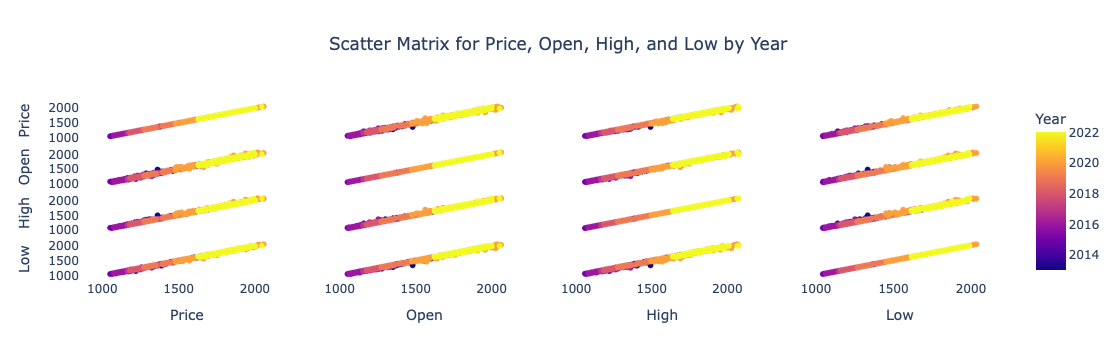

In [33]:
fig = px.scatter_matrix(
    goldprice,
    dimensions=['Price', 'Open', 'High', 'Low'],
    color='Year',
    title="Scatter Matrix for Price, Open, High, and Low by Year",
    labels={"Year": "Year"}
)
fig.update_layout(
    title_x=0.5,
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)'
)
fig.show()



Diagonal Pattern:
1. Each variable (Price, Open, High, Low) shows a clear positive correlation with the others, as seen by the diagonal clustering along a straight line in each scatter plot.
2. This indicates that when one variable increases, the others tend to increase as well.

Color Gradient:
1. The color gradient (from purple in 2014 to yellow in 2022) shows a progression over time.
2. Newer data points (2022) are located towards the higher end of each variable, suggesting an upward trend in prices over the years.

Close Alignment:
1. The plots indicate very close alignment between the variables, with minimal dispersion, which implies a strong linear relationship between Price, Open, High, and Low.
2. This could suggest that daily opening, high, low, and closing prices are tightly linked, with little volatility on a daily scale.

Consistent Pattern Across Years:
1. The pattern remains consistent across all years, though there is a noticeable upward shift in values from 2014 to 2022.
2. This aligns with the observation that gold prices have generally increased over the period covered by the data.

Overall, this scatter matrix confirms a strong, linear relationship between the different gold price metrics, with a gradual increase in values from 2014 to 2022.

**4.3 Correlation Matrix for Price, Open, High and Low**

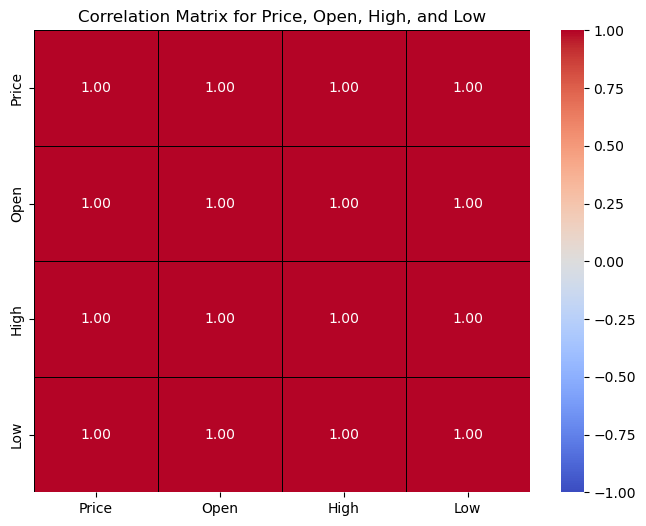

In [35]:
correlation_matrix = goldprice[['Price', 'Open', 'High', 'Low']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1,
            linewidths=0.5, linecolor='black')
plt.title("Correlation Matrix for Price, Open, High, and Low")
plt.show()

There is a perfectly strong positive correlation (1) among the price, open price, low price, and high price for the day. This means that these variables tend to move together and are highly dependent on each other, indicating that when one increases, the others likely increase as well.

**4.4 Histogram of Price, Open, High and Low**

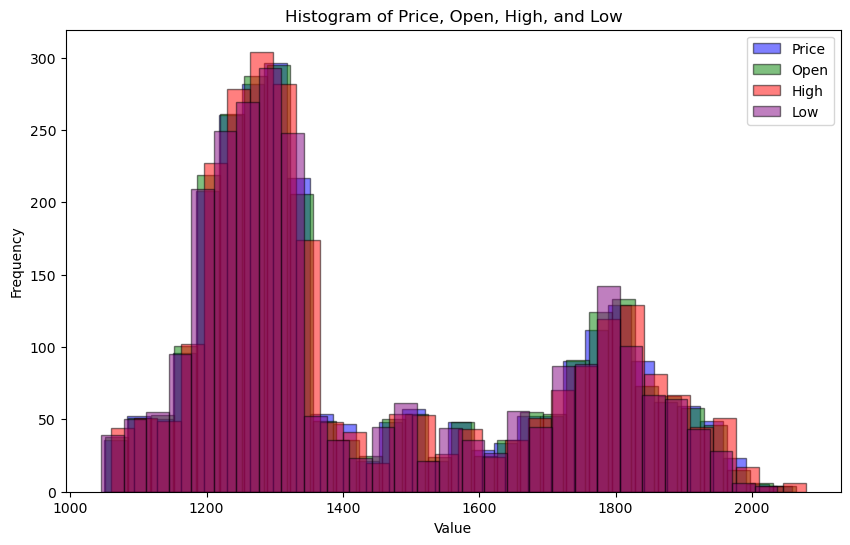

In [37]:
hist_data = {
    'Price': {'data': goldprice['Price'], 'color': 'blue', 'label': 'Price'},
    'Open': {'data': goldprice['Open'], 'color': 'green', 'label': 'Open'},
    'High': {'data': goldprice['High'], 'color': 'red', 'label': 'High'},
    'Low': {'data': goldprice['Low'], 'color': 'purple', 'label': 'Low'}
}
plt.figure(figsize=(10, 6))
for key, value in hist_data.items():
    plt.hist(value['data'], bins=30, color=value['color'], edgecolor='black', alpha=0.5, label=value['label'])
plt.title('Histogram of Price, Open, High, and Low')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()


1.	The Histogram shows that the variables (Price, Open, High, and Low) are almost identical, as the distributions seem to largely overlap
2.	The highest frequency is observed in the range of USD 1200 - 1400, where all four variables (price, opeon, low and high) have a significant number of occurrences, with a peak frequency exceeding 300
3.	There are smaller, secondary peaks where frequencies rise again, particularly around USD 1700-1800
4.	The frequency of occurrences for all the variables decreases as the price approaches USD 2000 and above, with much lower frequencies in this range
5.	The overall shape shows two primary clusters or peaks: one around USD 1200-1400 and another smaller one between USD 1700-1800



**5.0 DATA MINING MODELS**

**5.1 Train and test split for time series**

In time series forecasting, it's essential to split the data in a way that mimics real-world prediction scenarios, where we cannot use future data to predict the past. The proper way to split time series data is to use the earlier part of the data (up to a specific point in time) for training, so here we are using data from 2013 to 2022, and then use the later part (2023) for testing.


In [39]:
train_data = goldprice[goldprice.Date.dt.year < 2023]
test_data = goldprice[goldprice.Date.dt.year == 2022]

In [41]:
training_size = train_data.shape[0]
test_size = test_data.shape[0]
training_size, test_size

(2583, 260)

**5.2 Visualization of Train and Test Data Gold Price Plot**

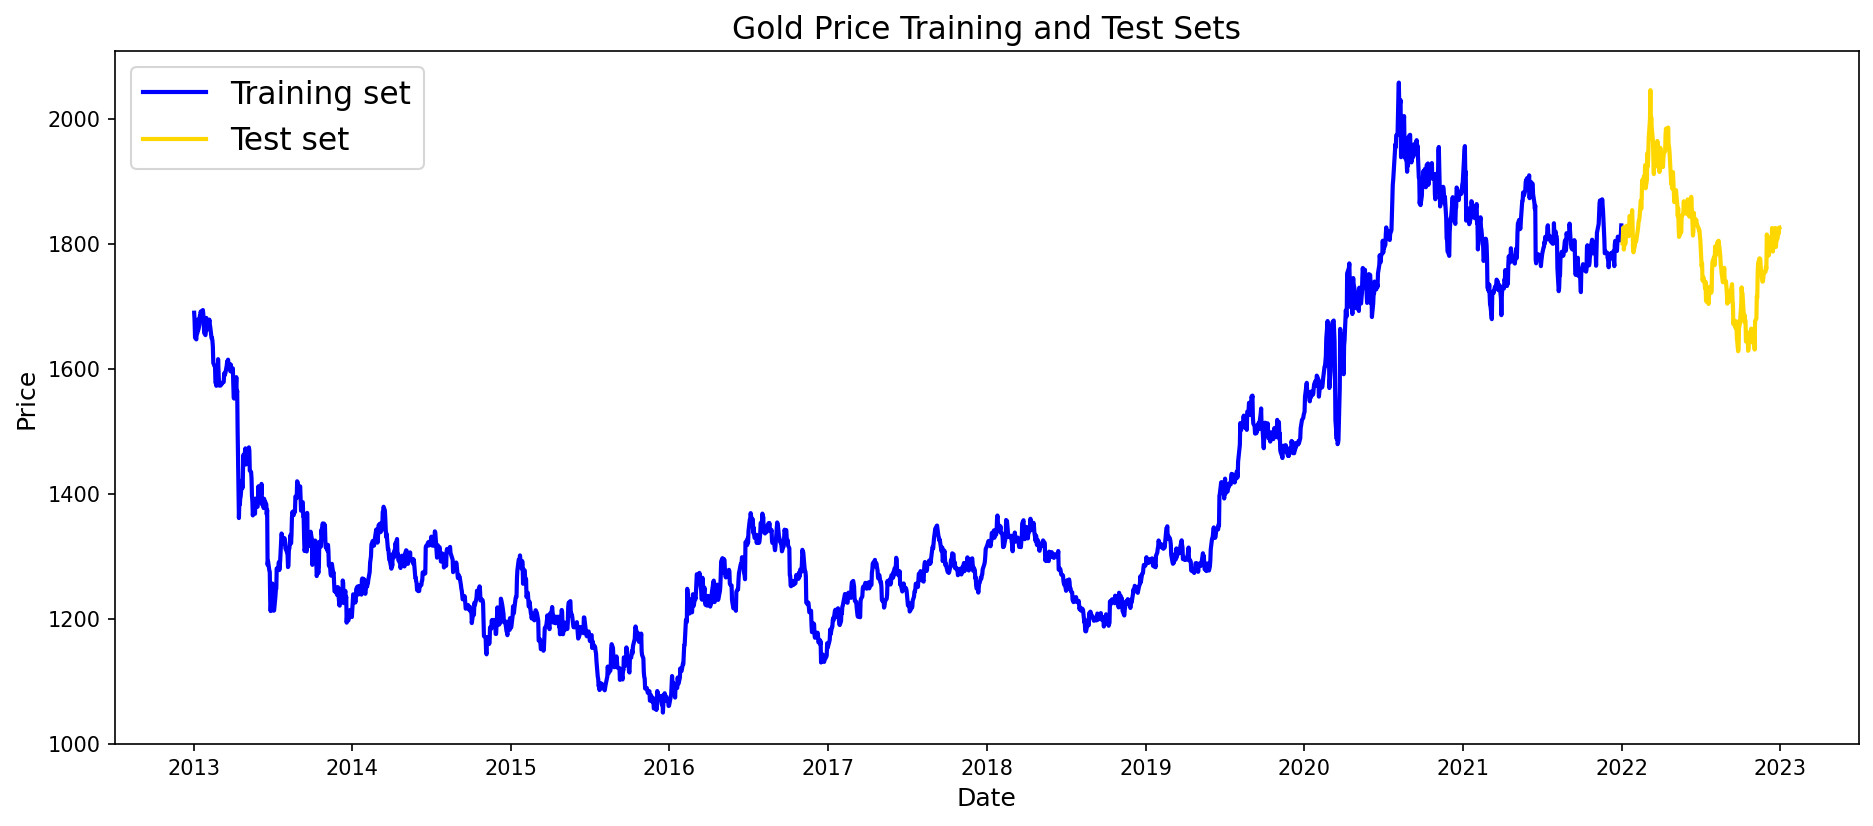

In [43]:
plt.figure(figsize=(15, 6), dpi=150)
plt.gca().set_facecolor('none')
plt.plot(goldprice.Date[:-test_size], goldprice.Price[:-test_size], color='blue', lw=2)
plt.plot(goldprice.Date[-test_size:], goldprice.Price[-test_size:], color='gold', lw=2)
plt.title('Gold Price Training and Test Sets', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15})
plt.grid(False)
plt.show()


**5.3 Scale Data**

In [45]:
scaler = StandardScaler()
scaler.fit(goldprice.Price.values.reshape(-1, 1))

StandardScaler()

**5.4 Preparing Data for Long Short-Term Memory (LSTM) Model**

Using sliding window technique on the training data itself to generate sequences. It creates multiple overlapping sequences within the training data. For each sequence of length window_size (e.g., 60 time steps), the model will learn to predict the next time step.

**5.4.1 Setting Window Size**

In [47]:
window_size = 60

**5.4.2 Training Set**

In [49]:
train_data = goldprice.Price[:-test_size]
train_data = scaler.transform(train_data.values.reshape(-1,1))

In [51]:
X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

**5.4.3 Test Set**

In [53]:
test_data = goldprice.Price[-test_size-60:]
test_data = scaler.transform(test_data.values.reshape(-1,1))

In [55]:
X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])

**5.4.4  Converting Data Into Numpy Arrays**

Useful to convert data into NumPy arrays, as they provide efficient storage and computation for numerical data. NumPy arrays allow for faster mathematical operations, easier manipulation, and are compatible with most machine learning frameworks, making them ideal for training and evaluating models. By using NumPy arrays, we can perform operations more efficiently, especially when dealing with large datasets.

In [57]:
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

In [59]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1,1))
y_test  = np.reshape(y_test, (-1,1))

In [61]:
print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_test Shape:  ', X_test.shape)
print('y_test Shape:  ', y_test.shape)

X_train Shape:  (2263, 60, 1)
y_train Shape:  (2263, 1)
X_test Shape:   (260, 60, 1)
y_test Shape:   (260, 1)


**5.4.5 Define Model**

In [63]:
def build_lstm_model():
    input_layer = Input(shape=(window_size, 1))
    x = LSTM(units=128, return_sequences=True)(input_layer)
    x = Dropout(0.3)(x)
    x = LSTM(units=128, return_sequences=True)(x)
    x = Dropout(0.3)(x)
    x = LSTM(units=128)(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    output_layer = Dense(1)(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='mean_absolute_error', optimizer=Adam())
    model.summary()

    return model


**5.4.6 Model Training**

In [73]:
model = build_lstm_model()
history = model.fit(X_train, y_train
, epochs=150, batch_size=32, validation_split=0.1, verbose=1)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 338,049 (1.29 MB)

 Trainable params: 338,049 (1.29 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 181ms/step - loss: 0.2484 - val_loss: 0.1918
Epoch 2/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 187ms/step - loss: 0.1096 - val_loss: 0.2130
Epoch 3/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 181ms/step - loss: 0.1113 - val_loss: 0.1443
Epoch 4/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 182ms/step - loss: 0.0965 - val_loss: 0.1648
Epoch 5/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 207ms/step - loss: 0.0969 - val_loss: 0.0884
Epoch 6/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - loss: 0.0908 - val_loss: 0.0778
Epoch 7/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0889 - val_loss: 0.2237
Epoch 8/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - loss: 0.0887 - val_loss: 0.0747
Epoch 9/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 174ms/step - loss: 0.0805 - val_loss: 0.0940
Epoch 10/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 0.0889 - val_loss: 0.0995
Epoch 11/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 192ms/step - loss: 0.0816 - val_loss: 0.1664
Epoch 12/150
64/64 ━━━━━━━━━━━

**5.4.7 Model Evaluation**

In [75]:
test_loss = model.evaluate(X_test, y_test, verbose=0)
y_pred = model.predict(X_test)

MAPE = mean_absolute_percentage_error(y_test, y_pred)
Accuracy = 1 - MAPE
RMSE = mean_squared_error(y_test, y_pred, squared=False)
R2 = r2_score(y_test, y_pred)

print("Test Loss:", round(test_loss, 4))
print("Test MAPE:", round(MAPE, 4))
print("Test Accuracy:", round(Accuracy * 100, 4), "%")
print("Test RMSE:", round(RMSE, 4))
print("Test R² Score:", round(R2, 4))



9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step
Test Loss: 0.0652
Test MAPE: 0.0468
Test Accuracy: 95.318 %
Test RMSE: 0.0866
Test R² Score: 0.94


In [104]:
y_test_true = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_pred)

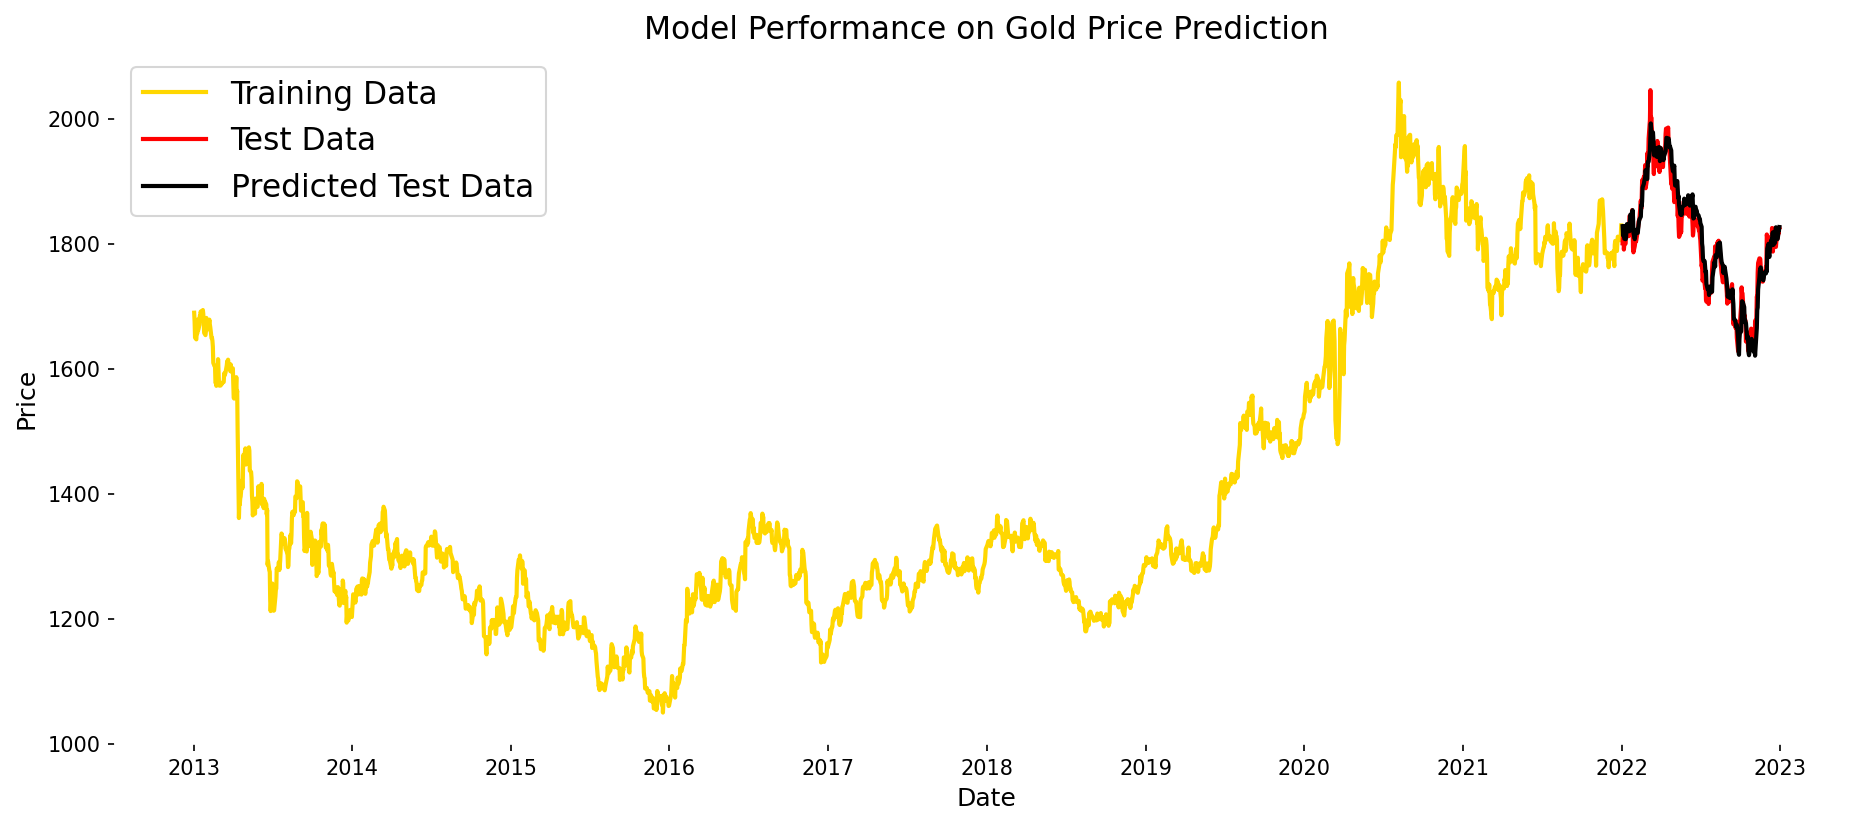

In [106]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes',edgecolor='white')
plt.plot(goldprice['Date'].iloc[:-test_size], scaler.inverse_transform(train_data), color='gold', lw=2)
plt.plot(goldprice['Date'].iloc[-test_size:], y_test_true, color='red', lw=2)
plt.plot(goldprice['Date'].iloc[-test_size:], y_test_pred, color='black', lw=2)
plt.title('Model Performance on Gold Price Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training Data', 'Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()



**5.5 Random Forest Model**

**5.5.1 Model Training**

Reshape X_train and X_test: reshape(-1) to flatten the last dimension, making X_train and X_test compatible with scikit-learn models that require 2D input.

In [104]:
X_train_2d = X_train.reshape(X_train.shape[0], -1)
X_test_2d = X_test.reshape(X_test.shape[0], -1)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_2d, y_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomForestRegressor(random_state=42)

**5.5.2 Model Evaluation**

In [105]:
y_pred_rf = rf_model.predict(X_test_2d)

mape_rf = mean_absolute_percentage_error(y_test, y_pred_rf)
accuracy_rf = 1 - mape_rf
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Results:")
print("MAPE:", round(mape_rf, 4))
print("Accuracy:", round(accuracy_rf * 100, 2), "%")
print("RMSE:", round(rmse_rf, 4))
print("R² Score:", round(r2_rf, 4))

Random Forest Results:
MAPE: 0.0521
Accuracy: 94.79 %
RMSE: 0.0865
R² Score: 0.9402


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



**5.5.3 Model Visualization**

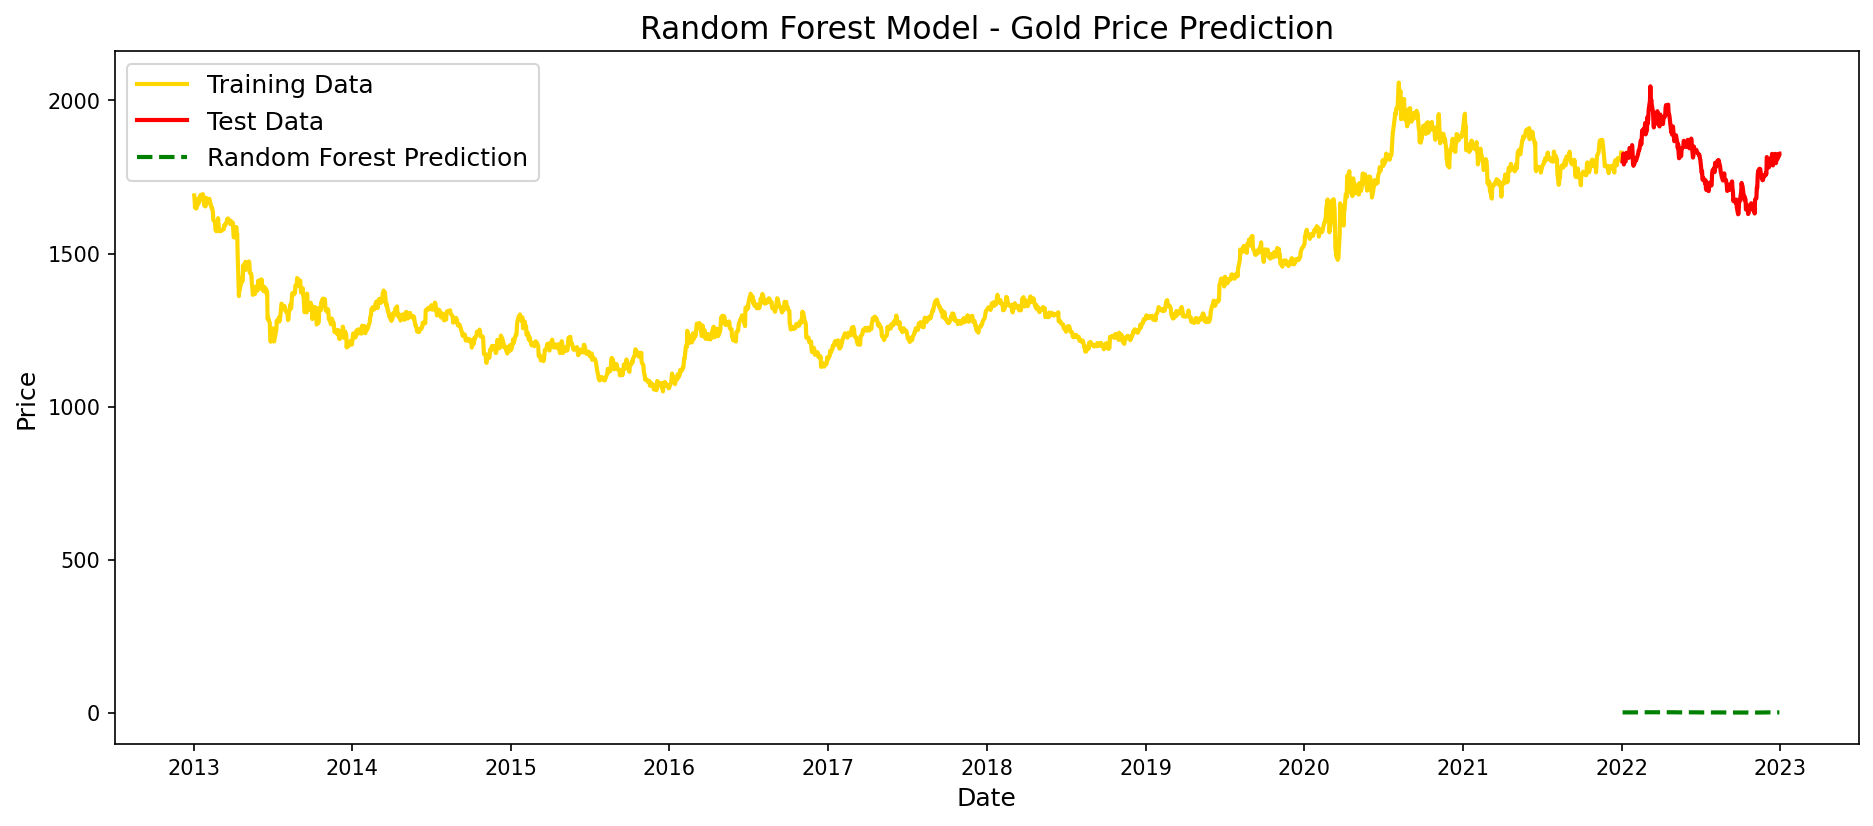

In [106]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes', edgecolor='black')

plt.plot(goldprice['Date'].iloc[:-test_size], scaler.inverse_transform(train_data), color='gold', lw=2, label='Training Data')
plt.plot(goldprice['Date'].iloc[-test_size:], y_test_true, color='red', lw=2, label='Test Data')
plt.plot(goldprice['Date'].iloc[-test_size:], y_pred_rf, color='green', lw=2, linestyle='--', label='Random Forest Prediction')

plt.title('Random Forest Model - Gold Price Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(loc='upper left', prop={'size': 12})
plt.show()


**5.6 XGBoost Model**

**5.6.1 Model Training**

In [116]:
# Reshape X_train and X_test to 2D arrays if needed
X_train_2d = X_train.reshape(X_train.shape[0], -1)
X_test_2d = X_test.reshape(X_test.shape[0], -1)

# Initialize and train the XGBoost model
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train_2d, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

**5.6.2 Model Evaluation**

In [118]:
y_pred_xgb = xgb_model.predict(X_test_2d)

mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb)
accuracy_xgb = 1 - mape_xgb
rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost Results:")
print("MAPE:", round(mape_xgb, 4))
print("Accuracy:", round(accuracy_xgb * 100, 2), "%")
print("RMSE:", round(rmse_xgb, 4))
print("R² Score:", round(r2_xgb, 4))

XGBoost Results:
MAPE: 0.0499
Accuracy: 95.01 %
RMSE: 0.0852
R² Score: 0.942


**5.6.3 Model Visualization**

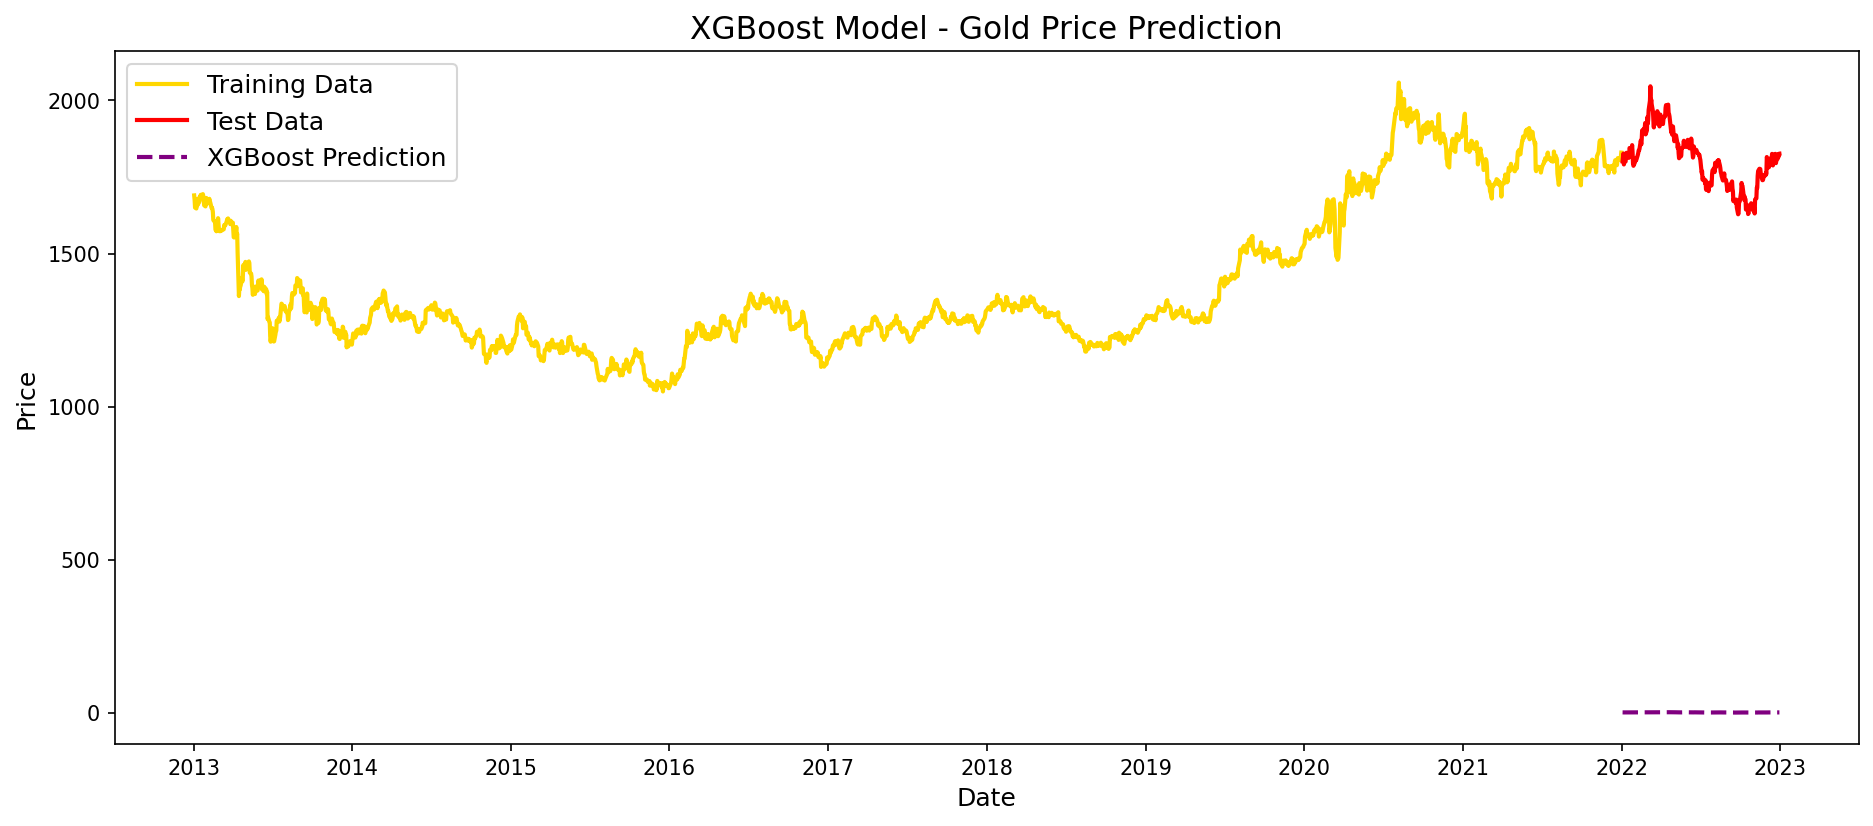

In [120]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes', edgecolor='black')

plt.plot(goldprice['Date'].iloc[:-test_size], scaler.inverse_transform(train_data), color='gold', lw=2, label='Training Data')
plt.plot(goldprice['Date'].iloc[-test_size:], y_test_true, color='red', lw=2, label='Test Data')
plt.plot(goldprice['Date'].iloc[-test_size:], y_pred_xgb, color='purple', lw=2, linestyle='--', label='XGBoost Prediction')

plt.title('XGBoost Model - Gold Price Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(loc='upper left', prop={'size': 12})
plt.show()


**5.7 Holt-Winters Exponential Smoothng**

**5.7.1 Model Training**

In [176]:
goldprice['Date'] = pd.to_datetime(goldprice['Date'])

# Split the data into train and test sets based on the year
train_data = goldprice[goldprice.Date.dt.year < 2023]
test_data = goldprice[goldprice.Date.dt.year == 2022]

# Set 'Date' as index for both train and test data
train_data.set_index('Date', inplace=True)
test_data.set_index('Date', inplace=True)


**5.7.2 Model Evaluation**

In [178]:
# Fit the Holt-Winters Exponential Smoothing model
hw_model = ExponentialSmoothing(train_data['Price'], trend='add', seasonal='add', seasonal_periods=12).fit()

# Forecast for the test period
hw_forecast = hw_model.forecast(steps=len(test_data))

# Convert forecast to pandas Series with the correct index
hw_forecast_series = pd.Series(hw_forecast, index=test_data.index)

# Evaluate the model
hw_mape = mean_absolute_percentage_error(test_data['Price'], hw_forecast)
hw_rmse = np.sqrt(mean_squared_error(test_data['Price'], hw_forecast))
hw_r2 = r2_score(test_data['Price'], hw_forecast)
hw_accuracy = (1 - hw_mape) * 100

# Print Evaluation Metrics for Holt-Winters
print(f"Holt-Winters Exponential Smoothing:")
print(f"MAPE: {hw_mape:.4f}")
print(f"RMSE: {hw_rmse:.4f}")
print(f"R² Score: {hw_r2:.4f}")
print(f"Accuracy: {hw_accuracy:.2f}%")


Holt-Winters Exponential Smoothing:
MAPE: 0.0785
RMSE: 167.3543
R² Score: -2.3788
Accuracy: 92.15%


**5.7.3 Model Visualization**

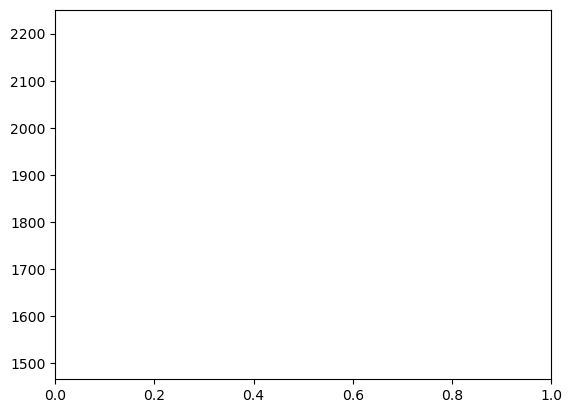

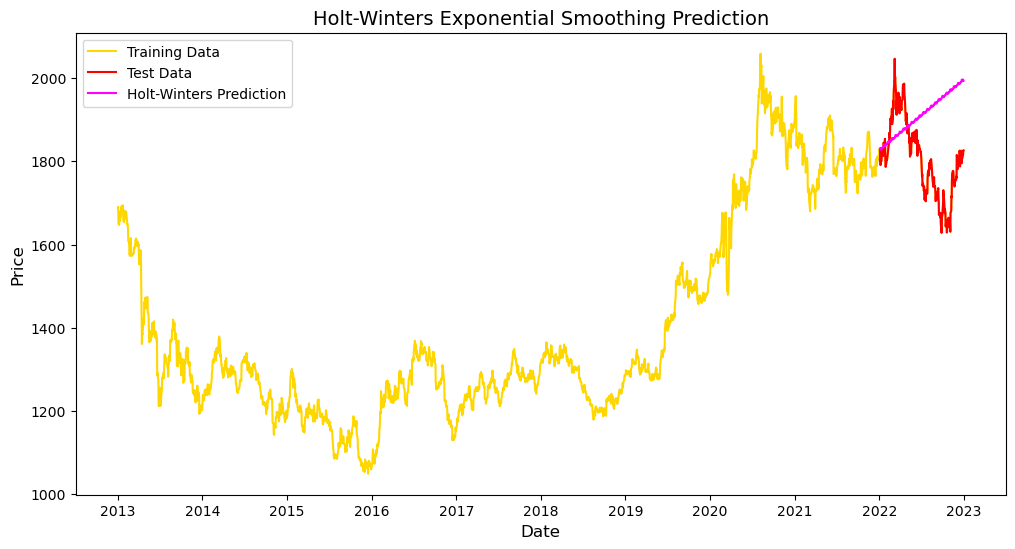

In [212]:
hw_forecast_series = pd.Series(hw_forecast, index=test_data.index)

# Adjust Y-axis range for better visibility
plt.ylim(test_data['Price'].min() * 0.9, test_data['Price'].max() * 1.1)

plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Price'], color='gold', label='Training Data')
plt.plot(test_data.index, test_data['Price'], color='red', label='Test Data')
plt.plot(hw_forecast_series.index, hw_forecast_series, color='magenta', label='Holt-Winters Prediction')

plt.title("Holt-Winters Exponential Smoothing Prediction", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.legend(loc='upper left')
plt.show()


**5.8 AutoRgressive Integrated MovingAverage (ARIMA):**

**5.8.1 Model Training**

In [407]:
goldprice['Date'] = pd.to_datetime(goldprice['Date'])
train_data = goldprice[goldprice.Date.dt.year < 2023]
test_data = goldprice[goldprice.Date.dt.year == 2022]

# Set 'Date' as index for both train and test data
train_data.set_index('Date', inplace=True)
test_data.set_index('Date', inplace=True)

# Fit the ARIMA model (choose appropriate order based on analysis, e.g., ARIMA(2,1,2))
arima_model = ARIMA(train_data['Price'], order=(2, 1, 2)).fit()

# Prediction for the test period
arima_forecast = arima_model.forecast(steps=len(test_data))

# Convert prediction to pandas Series with the correct index
arima_forecast_series = pd.Series(arima_forecast, index=test_data.index)

**5.8.1 Model Evaluation**

In [409]:
arima_mape = mean_absolute_percentage_error(test_data['Price'], arima_forecast)
arima_rmse = np.sqrt(mean_squared_error(test_data['Price'], arima_forecast))
arima_r2 = r2_score(test_data['Price'], arima_forecast)
arima_accuracy = (1 - arima_mape) * 100

print(f"ARIMA Model:")
print(f"MAPE: {arima_mape:.4f}")
print(f"RMSE: {arima_rmse:.4f}")
print(f"R² Score: {arima_r2:.4f}")
print(f"Accuracy: {arima_accuracy:.2f}%")


ARIMA Model:
MAPE: 0.0423
RMSE: 93.7509
R² Score: -0.0603
Accuracy: 95.77%


**5.8.1 Model Visualization**

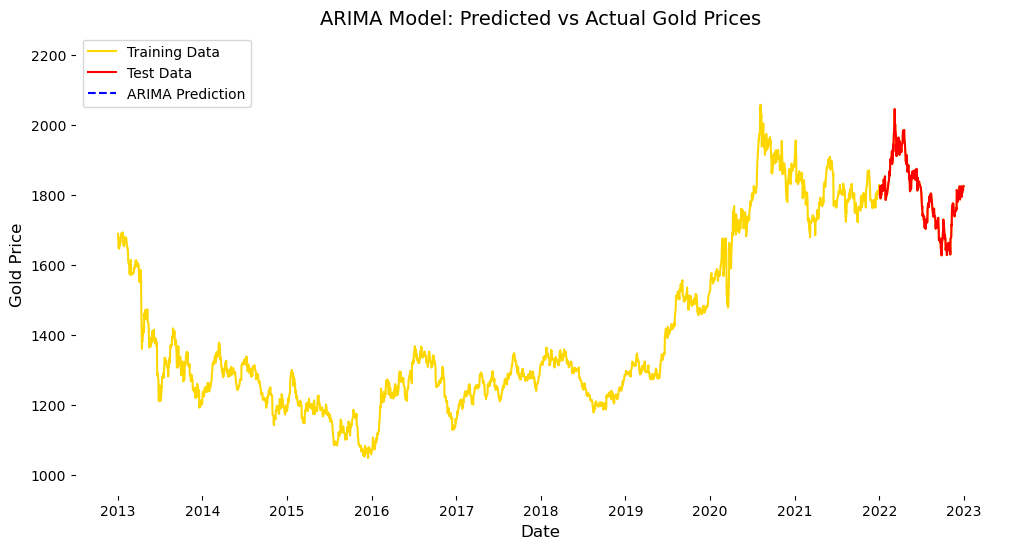

In [411]:
# Convert ARIMA forecast to pandas Series with the correct index
arima_forecast_series = pd.Series(arima_forecast, index=test_data.index)

plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Price'], color='gold', label='Training Data')
plt.plot(test_data.index, test_data['Price'], color='red', label='Test Data')
plt.plot(arima_forecast_series.index, arima_forecast_series, color='blue', linestyle='--', label='ARIMA Prediction')

# Dynamically adjust Y-axis range to include predictions
plt.ylim(
    min(train_data['Price'].min(), test_data['Price'].min(), arima_forecast_series.min()) * 0.9,
    max(train_data['Price'].max(), test_data['Price'].max(), arima_forecast_series.max()) * 1.1,
)

plt.title("ARIMA Model: Predicted vs Actual Gold Prices", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Gold Price", fontsize=12)
plt.legend(loc='upper left')
plt.show()


**5.9 Prediction Error Visualization For All Models**

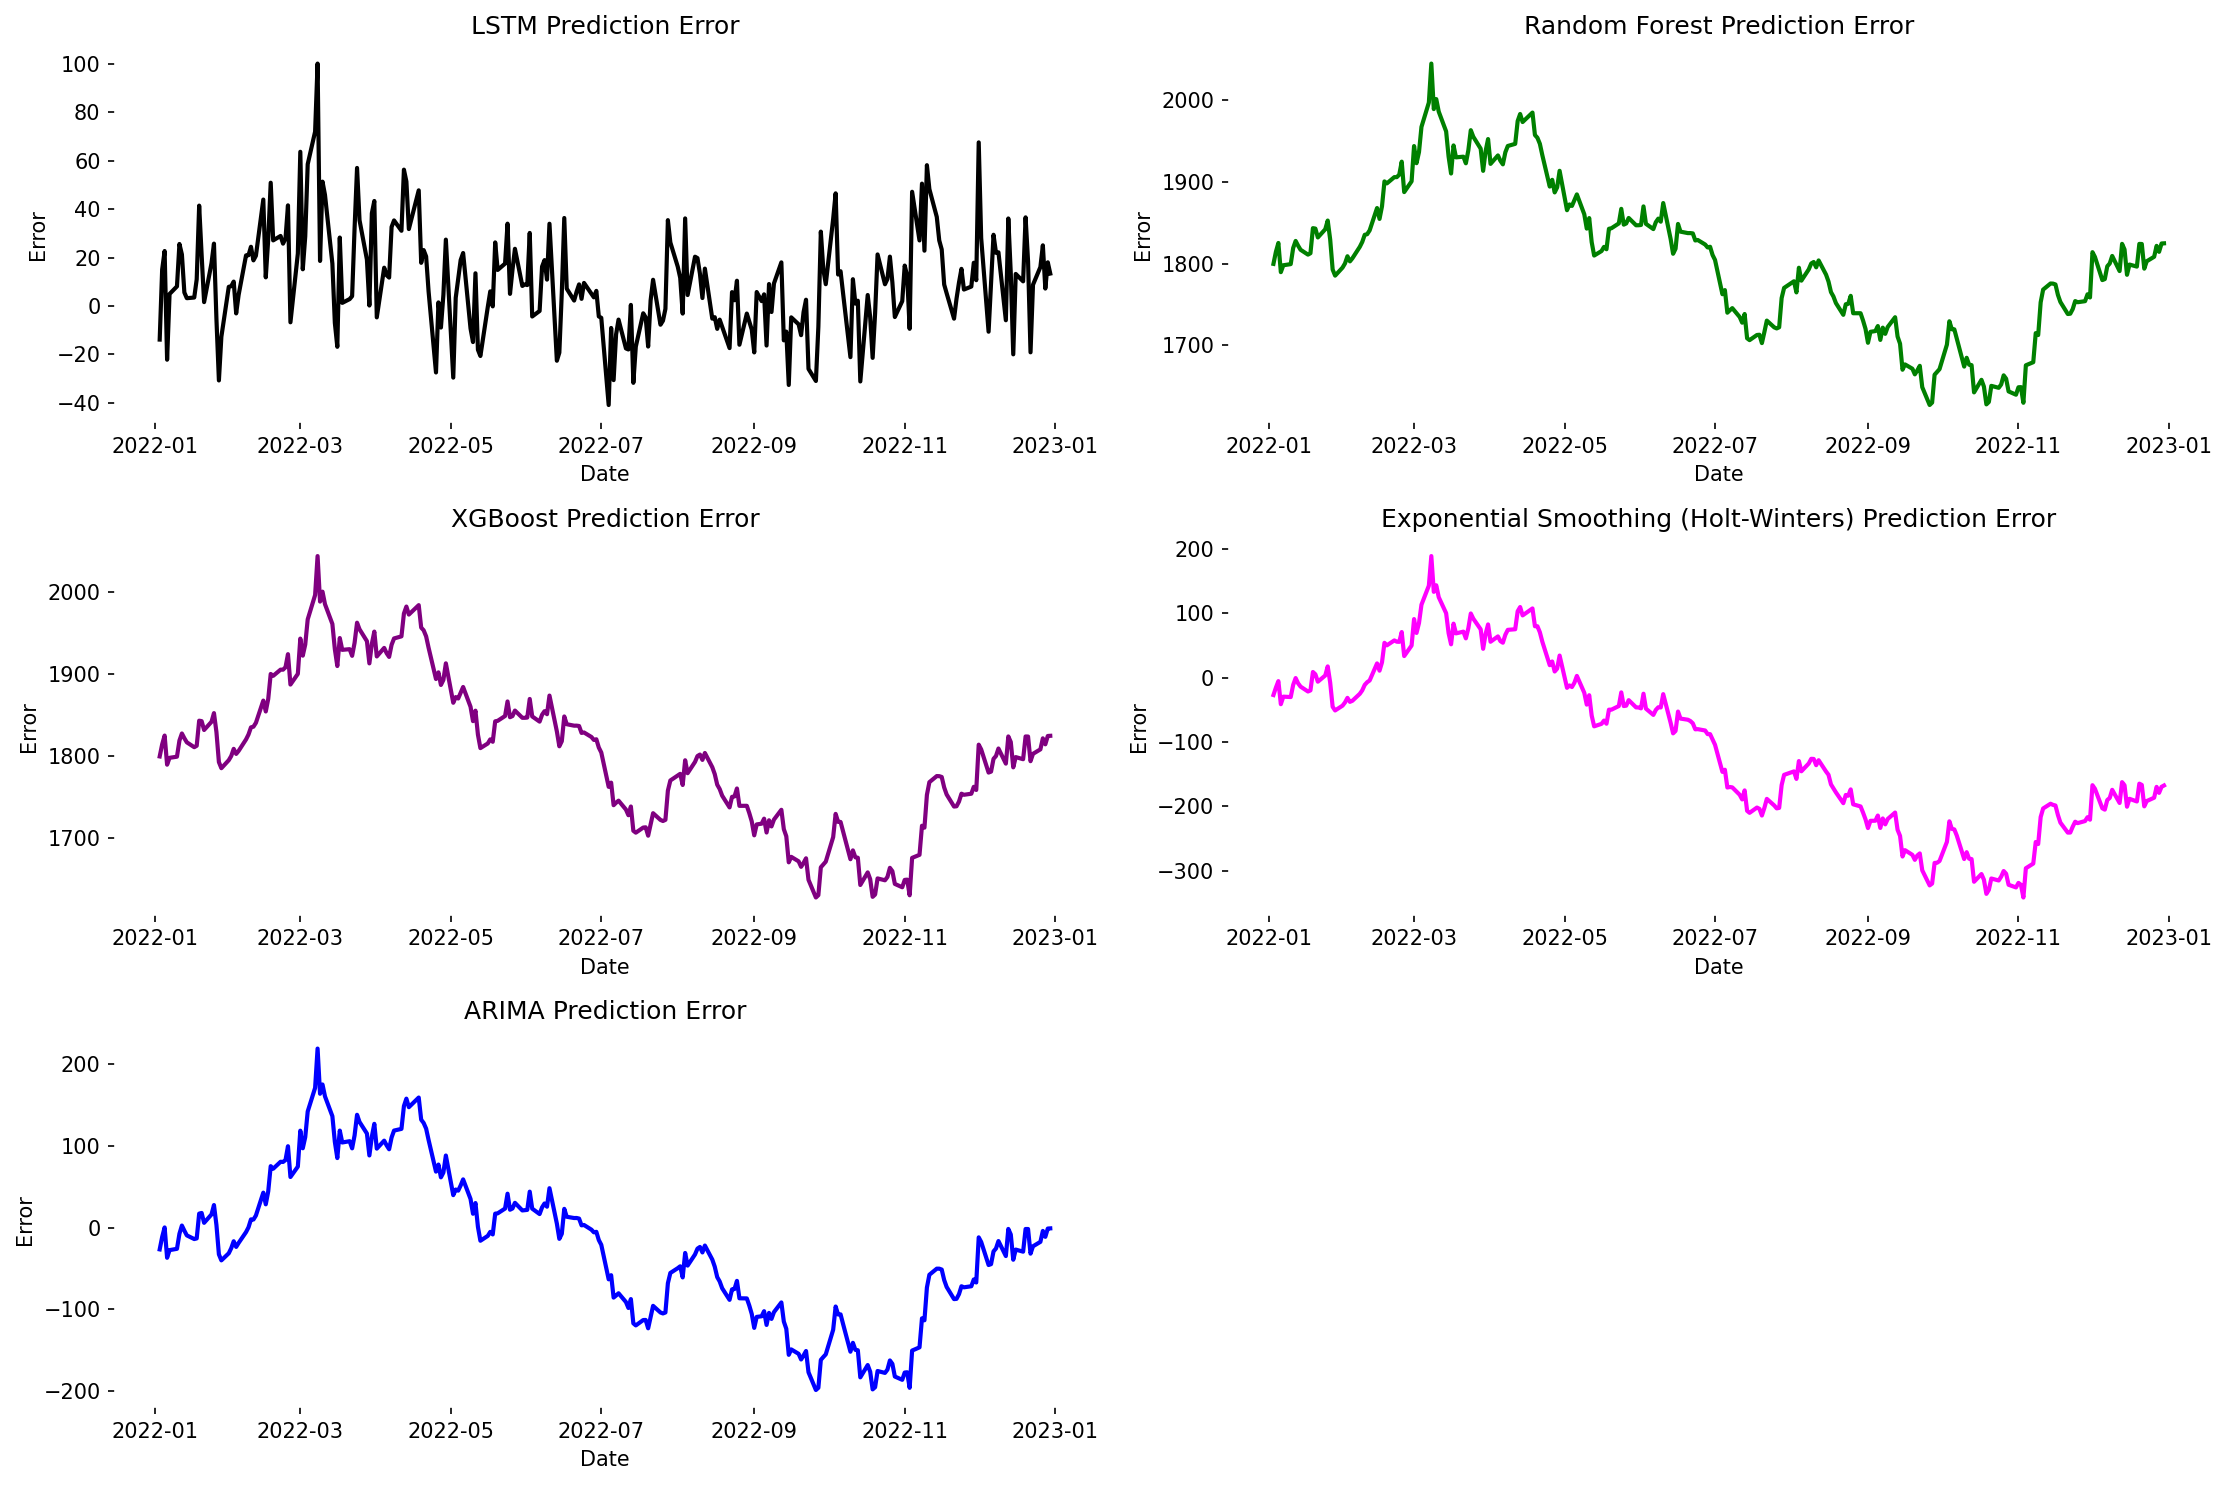

In [403]:
# Ensure that all prediction and true values are 1-dimensional
y_test_true = y_test_true.ravel()
y_test_pred = y_test_pred.ravel()
y_pred_rf = y_pred_rf.ravel()
y_pred_xgb = y_pred_xgb.ravel()
hw_forecast = hw_forecast.ravel()
arima_forecast = arima_forecast.ravel()

# Compute prediction errors for each model
error_lstm = y_test_true - y_test_pred
error_rf = y_test_true - y_pred_rf
error_xgb = y_test_true - y_pred_xgb
error_hw = y_test_true - hw_forecast
error_arima = y_test_true - arima_forecast

# Ensure consistent date range for the x-axis for all subplots (use test_data.index)
date_range = test_data.index

# Set up the figure for subplots
fig, axs = plt.subplots(3, 2, figsize=(15, 10), dpi=150)

# LSTM Error
axs[0, 0].plot(date_range, error_lstm, color='black', lw=2)
axs[0, 0].set_title('LSTM Prediction Error')
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('Error')

# Random Forest Error
axs[0, 1].plot(date_range, error_rf, color='green', lw=2)
axs[0, 1].set_title('Random Forest Prediction Error')
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel('Error')

# XGBoost Error
axs[1, 0].plot(date_range, error_xgb, color='purple', lw=2)
axs[1, 0].set_title('XGBoost Prediction Error')
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel('Error')

# Exponential Smoothing (Holt-Winters) Error
axs[1, 1].plot(date_range, error_hw, color='magenta', lw=2)
axs[1, 1].set_title('Exponential Smoothing (Holt-Winters) Prediction Error')
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel('Error')

# ARIMA Error
axs[2, 0].plot(date_range, error_arima, color='blue', lw=2)
axs[2, 0].set_title('ARIMA Prediction Error')
axs[2, 0].set_xlabel('Date')
axs[2, 0].set_ylabel('Error')

# Remove the last subplot (empty slot)
axs[2, 1].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


This graph shows the prediction errors of various models (LSTM, Random Forest, XGBoost, Exponential Smoothing, and ARIMA) used to forecast gold prices from 2012 to 2023. 

LSTM (Long Short-Term Memory) Model:
The error fluctuates around zero, with less variability compared to other models.
The range of error is narrower (approximately between -125 and 50), indicating better predictive accuracy.
This suggests LSTM captures the patterns in the gold price data effectively.

Random Forest Model:
Errors are consistently high, fluctuating around 1800 to 2000, suggesting this model struggles to predict gold prices accurately.
This could indicate that Random Forest fails to capture temporal dependencies or nonlinear trends in the data.

XGBoost Model:
Errors are high, similar to Random Forest, but show a smoother trend with fewer sharp fluctuations.
While better than Random Forest, XGBoost also seems unsuitable for this time-series prediction due to high residuals.

Exponential Smoothing (Holt-Winters):
Errors show significant variability (ranging from -300 to 200).
This model performs better than Random Forest and XGBoost but struggles during periods of sharp changes in gold prices.

ARIMA (AutoRegressive Integrated Moving Average):
Errors are high at specific points but fluctuate less dramatically than XGBoost or Random Forest.
The model shows some capability to capture trends but performs poorly in dynamic or volatile periods.

Meaning and Influence on Gold Price Prediction:

Error Significance:
Prediction error indicates how far the model's predicted values deviate from actual gold prices. Lower error means better accuracy.
LSTM's lower and consistent error suggests it handles the complexities of gold price dynamics, such as seasonality, trends, and sudden changes.

Implications for Gold Price Prediction:
The performance of these models influences the reliability of gold price forecasts. Accurate predictions are essential for financial analysis, trading, and decision-making.
LSTM's better performance suggests it can be trusted more for tasks like predicting future trends or assessing investment risks.

Model Suitability:
Time-series data like gold prices often have nonlinear patterns, trends, and noise. Models like LSTM, which are designed to handle sequential data, excel here.
Tree-based models (Random Forest, XGBoost) are less suitable for such tasks unless features like temporal lags are manually engineered.